# Inspect dME-model properties

Code for reproducing panels of Figure 3

## Setup environment

In [3]:
import coralme
from coralme.builder.helper_functions import *
import pickle
import pandas
import os
import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import sympy
pandas.set_option('display.max_colwidth', None)
plt.rcParams['svg.fonttype'] = 'none'

## Functions to load and inspect models

Load a ME-model

In [3]:
def load_me(filename='me_model.pickle'):
    with open(filename, "rb") as f:
        return pickle.load(f)

Get contigs from GenBank file

In [3]:
def get_genbank_contigs(path):
    import Bio
    gb_it = Bio.SeqIO.parse(path, "gb")
    return [ i for i in gb_it ]

Get property breakdown from a model

In [4]:
def get_info(model, info_flag='all'):
    if info_flag == 'all':
        return {
            'genes':len([i for i in model.genes if 'dummy' not in i.id]),
            'reactions':len(model.reactions),
            'metabolites':len(model.metabolites),
        }
    else:
        return get_breakdown(model,info_flag)

def get_breakdown(model,field):
    count = {}
    for instance in getattr(model,field):
        instance_type = instance.__class__.__name__
        if instance_type not in count.keys():
            count[instance_type] = 0
        count[instance_type] += 1
    return {'genes':count}

Get organism directories in path

In [5]:
def get_org_dirs(directory):
    return [i for i in os.listdir(directory) \
            if os.path.isdir(directory+i) and '.' not in i and '_' not in i]

Load models in a directory

In [6]:
def load_models_from_directory(directory,solve=False):
    d = {}
    dirs = get_org_dirs(directory)
    for i in tqdm.tqdm(dirs):
        modelpath = directory + '{}/MEModel-step2-{}.pkl'.format(i,i)
        d[i] = load_me(modelpath)
        if solve:
            d[i].optimize()
    return d

Main function to get and summarize ME-model properties

In [7]:
def get_specs(models, info_flag = 'all'):
    info = {}
    for k,v in models.items():
        for i,m in v.items():
            m.genes = [g for g in m.metabolites if isinstance(g,coralme.core.component.TranscribedGene)]
            name = i
            if name not in info:
                info[name] = {}
            info[name]['mmodel'] = get_info(m.gem, info_flag=info_flag)['genes']
            if 'clean' in k:
                info[name]['coralme'] = get_info(m, info_flag=info_flag)['genes']
            else:
                info[name]['curated'] = get_info(m, info_flag=info_flag)['genes']
            if info_flag == 'all':
                if name in published_info:
                    info[name]['published'] = published_info[name]['genes']
                info[name]['genome'] = features[name]
    if info_flag == 'all':
        return pandas.DataFrame.from_dict(info).fillna(0).T[['mmodel','coralme','curated','published','genome']].sort_values('published',ascending=True)
    return pandas.DataFrame.from_dict(info).fillna(0).T 

## Load Genomes

In [8]:
features = {}
for org in get_org_dirs('./clean/'):
    p = './clean/{}/inputs/genome.gb'.format(org)
    contigs = get_genbank_contigs(p)
    count = 0
    for c in contigs:
        for f in c.features:
            if not f.type == 'gene': continue
            count += 1
    features[org] = count

## Load dME-models

In [9]:
models = {
    'curated':load_models_from_directory('./published/'),
    'clean':load_models_from_directory('./clean/')
         }

 25%|██▌       | 1/4 [00:00<00:02,  1.24it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file /tmp/tmppcg4efr8.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp3z2fu9r7.lp
Reading time = 0.00 seconds
: 1660 rows, 4754 columns, 17902 nonzeros
Read LP format model from file /tmp/tmpzq9vk6mp.lp
Reading time = 0.00 seconds
: 1811 rows, 5222 columns, 17878 nonzeros


 10%|▉         | 2/21 [00:01<00:14,  1.35it/s]

Read LP format model from file /tmp/tmph4kwmpee.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpndi__54d.lp
Reading time = 0.01 seconds
: 1802 rows, 5090 columns, 19612 nonzeros
Read LP format model from file /tmp/tmpyj5w1774.lp
Reading time = 0.01 seconds
: 1817 rows, 5084 columns, 19460 nonzeros


 38%|███▊      | 8/21 [00:17<00:28,  2.20s/it]

Read LP format model from file /tmp/tmpkt3enrqj.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpxwfnciq0.lp
Reading time = 0.00 seconds
: 649 rows, 1508 columns, 6436 nonzeros
Read LP format model from file /tmp/tmpb_viv2w2.lp
Reading time = 0.00 seconds
: 651 rows, 1504 columns, 6386 nonzeros


 71%|███████▏  | 15/21 [00:29<00:09,  1.54s/it]

Read LP format model from file /tmp/tmp79wdo_9n.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpy20scpb0.lp
Reading time = 0.00 seconds
: 768 rows, 1698 columns, 7642 nonzeros
Read LP format model from file /tmp/tmp4ghnbpr_.lp
Reading time = 0.00 seconds
: 787 rows, 1692 columns, 7596 nonzeros


100%|██████████| 21/21 [00:37<00:00,  1.80s/it]


In [10]:
# Temporary while rodrigo gives me the E. coli model
models['curated']['ecoli']._mu = sympy.Symbol("sigma")

## Load information of published ME-models

In [11]:
with open('published_info.json') as f:
    published_info = json.load(f)
with open('names.json') as f:
    names = json.load(f)

## Visualize ME-model specs

Specifications

In [12]:
specs_df = get_specs(models).rename(names)
specs_df

,mmodel,coralme,curated,published,genome
V. cholerae,960.0,1301.0,0.0,0.0,4007.0
L. crescens,373.0,508.0,0.0,0.0,1435.0
S. elongatus,785.0,974.0,0.0,0.0,2712.0
H. pylori,339.0,534.0,0.0,0.0,1584.0
Y. pestis,815.0,1031.0,0.0,0.0,4195.0
P. putida,1462.0,1661.0,0.0,0.0,5786.0
S. aureus,866.0,1050.0,0.0,0.0,2885.0
L. cremoris,516.0,696.0,0.0,0.0,2587.0
C. difficile,900.0,1200.0,0.0,0.0,4016.0
G. metallireducens,987.0,1164.0,0.0,0.0,3685.0


## Inspecting genes

Distribution of gene increase from M-model to dME-model

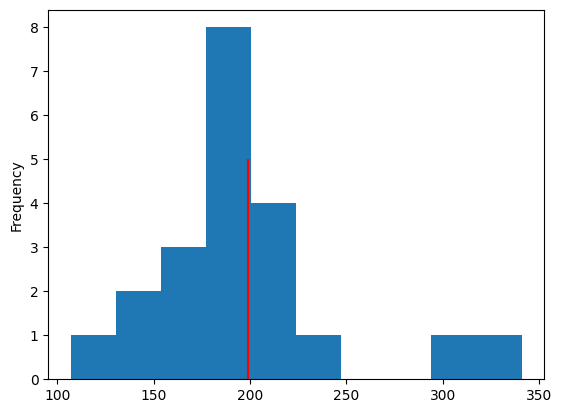

In [13]:
tmp = (specs_df['coralme'] - specs_df['mmodel'])
tmp.plot.hist()
plt.vlines(x=tmp.mean(), ymin = 0, ymax = 5, color='r')
plt.savefig('figures/added_genes_dist.svg',format='SVG')

Gene increase from M-model to dME-model

In [14]:
tmp.sort_values()

M. mycoides           107.0
L. crescens           135.0
T. maritima           144.0
Synechocystis         155.0
N. europaea           162.0
G. metallireducens    177.0
L. cremoris           180.0
S. aureus             184.0
S. elongatus          189.0
A. baumannii          194.0
H. pylori             195.0
P. putida             199.0
M. tuberculosis       199.0
B. subtilis           199.0
S. enterica           215.0
Y. pestis             216.0
S. flexneri           217.0
C. ljungdahlii        223.0
E. coli               244.0
C. difficile          300.0
V. cholerae           341.0
dtype: float64

Gene increase from M-model to dME-model for published ME-models

In [15]:
colors = ['#848484','#80B3DF','#5282AC','#FFAD65']
gene_df = specs_df.drop('genome',axis=1)[['mmodel','coralme','published','curated']]
df = gene_df

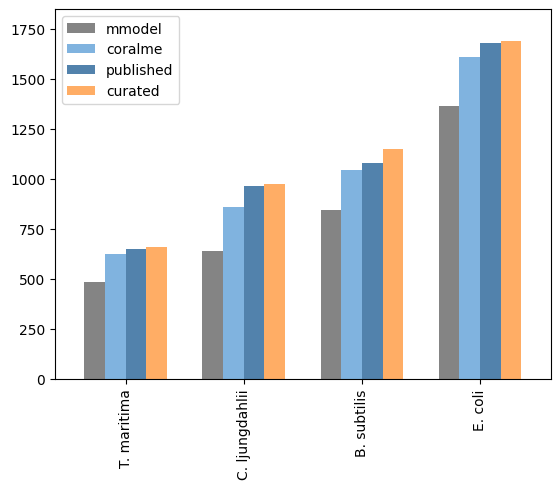

In [16]:
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']>0].sort_values('curated').plot.bar(
                                   width=0.7,color=colors)
plt.ylim([0,1850])
plt.savefig('./figures/Fig2c.svg',format='SVG')

Gene increase from M-model to dME-model for all other organisms

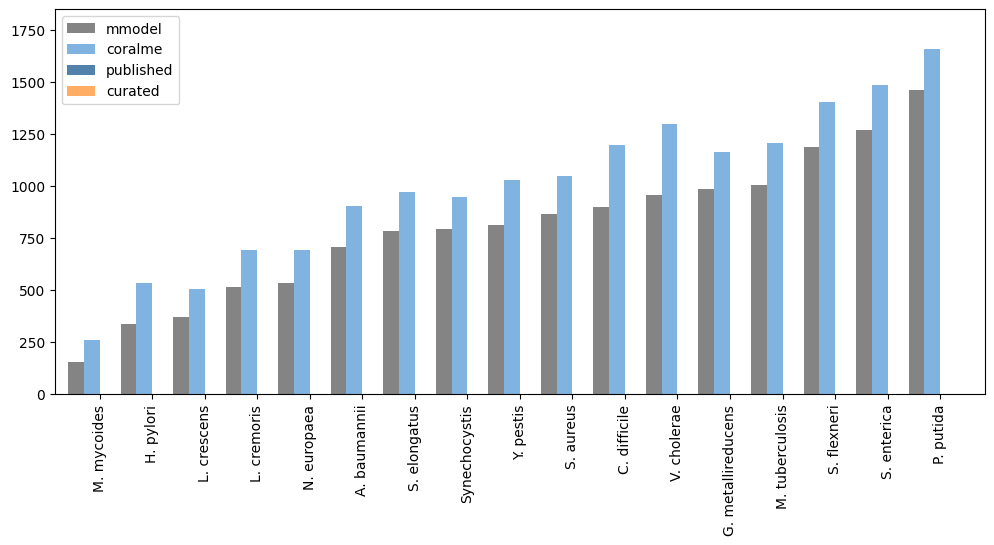

In [17]:
import pandas
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']==0].sort_values('mmodel').plot.bar(figsize=(12,5),
                                   width=1.2,
                                   color=colors)
plt.ylim([0,1850])

plt.savefig('./figures/Fig2a.svg',format='SVG')

## Genome coverage

Number of genes in all genomes

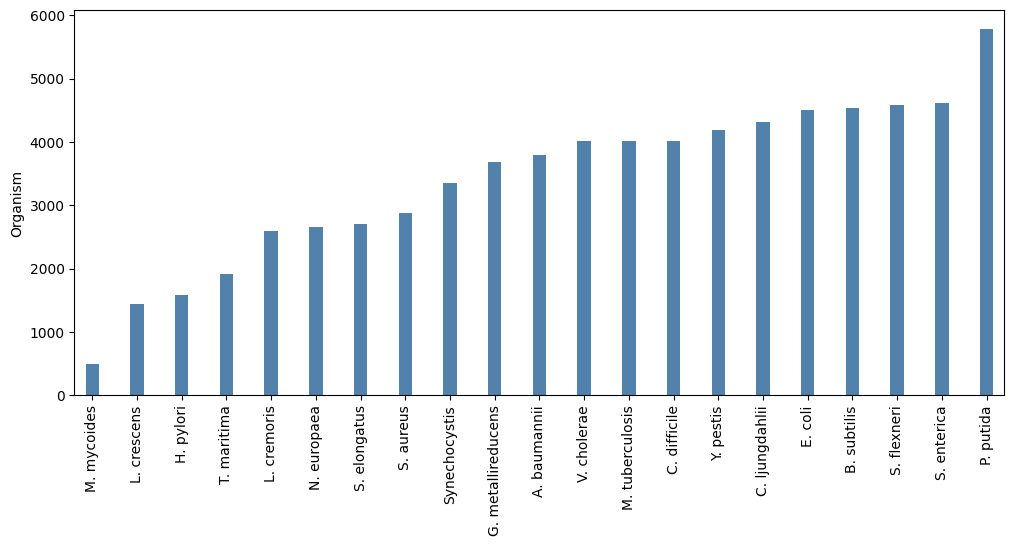

In [18]:
specs_df['genome'].sort_values().plot.bar(color=colors[2], figsize=(12,5),width=0.3)
plt.ylabel('Genome size, # of genes')
plt.ylabel('Organism')
plt.savefig('./figures/genome_sizes.svg',format='SVG')

Coverage of M- and ME-models

In [19]:
colors = ['#848484','#80B3DF','#5282AC','#FFAD65']
cov_df = specs_df.div(specs_df['genome'],axis=0).drop('genome',axis=1)[['mmodel','coralme','published','curated']]
cov_df

,mmodel,coralme,published,curated
V. cholerae,0.239581,0.324682,0.000000,0.000000
L. crescens,0.259930,0.354007,0.000000,0.000000
S. elongatus,0.289454,0.359145,0.000000,0.000000
H. pylori,0.214015,0.337121,0.000000,0.000000
Y. pestis,0.194279,0.245769,0.000000,0.000000
P. putida,0.252679,0.287072,0.000000,0.000000
S. aureus,0.300173,0.363951,0.000000,0.000000
L. cremoris,0.199459,0.269037,0.000000,0.000000
C. difficile,0.224104,0.298805,0.000000,0.000000
G. metallireducens,0.267843,0.315875,0.000000,0.000000


Change in coverage of from M- to dME-models

In [20]:
(cov_df['coralme'] - cov_df['mmodel']).sort_values()

P. putida             0.034393
B. subtilis           0.043871
Synechocystis         0.046172
S. enterica           0.046658
S. flexneri           0.047401
G. metallireducens    0.048033
M. tuberculosis       0.049651
A. baumannii          0.051187
Y. pestis             0.051490
C. ljungdahlii        0.051644
E. coli               0.054258
N. europaea           0.060902
S. aureus             0.063778
L. cremoris           0.069579
S. elongatus          0.069690
C. difficile          0.074701
T. maritima           0.075078
V. cholerae           0.085101
L. crescens           0.094077
H. pylori             0.123106
M. mycoides           0.215726
dtype: float64

Change in coverage of from M- to published ME-models

In [21]:
(cov_df['curated'] - cov_df['published']).sort_values(ascending=False).head(4)

B. subtilis       0.015212
T. maritima       0.005214
E. coli           0.002446
C. ljungdahlii    0.001621
dtype: float64

Coverage increase from M-model to dME-model for published ME-models

In [22]:
df = cov_df

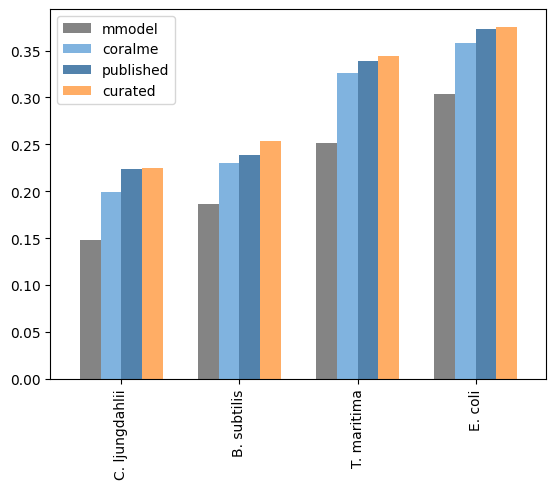

In [23]:
import pandas
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']>0].sort_values('curated').plot.bar(
                                   width=0.7,color=colors)
plt.savefig('./figures/Fig2c1.svg',format='SVG')

Coverage increase from M-model to dME-model for all other organisms

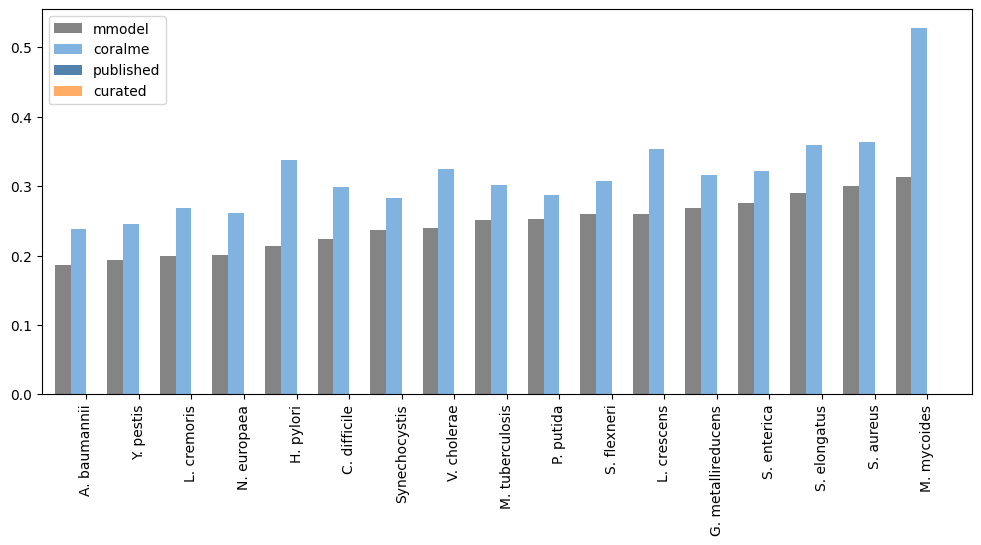

In [24]:
import pandas
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']==0].sort_values('mmodel').plot.bar(figsize=(12,5),
                                   width=1.2,
                                   color=colors)
plt.savefig('./figures/Fig2a1.svg',format='SVG')

Visualize the same information as heatmaps

In [25]:
import seaborn as sns

In [26]:
cmap = plt.cm.get_cmap('Reds').copy()
# cmap.set_bad('midnightblue')      # color of mask on heatmap
cmap.set_under('white')

/tmp/ipykernel_146904/2376249781.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds').copy()


Re-order organisms to see the increase more clearly

In [27]:
mlist = [names[i] for i in models['curated']]
df2 = df.loc[mlist][['mmodel','coralme','published','curated']]
df1 = df.drop(mlist)[['mmodel','coralme']].dropna()
order1 = [i for i in cov_df["mmodel"].sort_values().index if i in df1.index]
df1 = df1.loc[order1]
order2 = [i for i in cov_df["mmodel"].sort_values().index if i in df2.index]
df2 = df2.loc[order2]

Plot for published ME-models

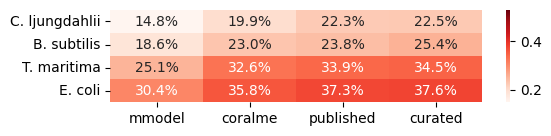

In [28]:
fig,ax = plt.subplots(figsize = (1.5 * df2.shape[1], 0.3 * df2.shape[0]))
sns.heatmap(df2, vmin=df[df>0].min().min(),vmax=df[df>0].max().max(), annot=True,fmt=".1%",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2d.svg',format='SVG')

Plot for all other ME-models

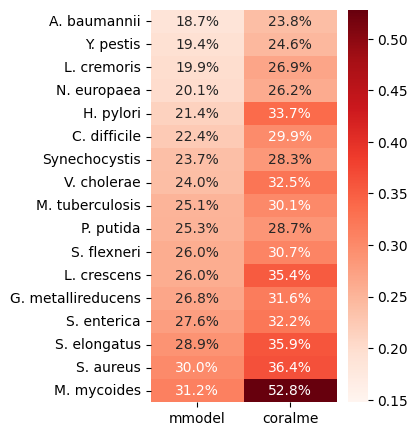

In [29]:
fig,ax = plt.subplots(figsize = (1.5 * df1.shape[1], 0.3 * df1.shape[0]))
sns.heatmap(df1, vmin=df[df>0].min().min(),vmax=df[df>0].max().max(), annot=True,fmt=".1%",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2b.svg',format='SVG')

## Inspect mapped gene functions in the ME-models

Function to get gene functions

In [30]:
def get_functions(dct):
    from collections import defaultdict
    functions = defaultdict()
    for k,me in dct.items():
        d = defaultdict(int)
        for g in me.all_genes:
            if not g.functions:
                d['none'] += 1
                continue
            for f in g.functions:
                d[f] += 1
        functions[names[k]] = d
    return functions

Get gene functions in the dME-models

In [31]:
fct1 = get_functions(models['clean'])

Get gene functions in the uME-models

In [32]:
fct2 = get_functions(models['curated'])

Summarize the gene functions in dataframes

In [33]:
functions = ['Translation','tRNA-Charging','Post-translation','Transcription']
df1 = pandas.DataFrame.from_dict(fct1).T.fillna(0)[functions + ['none']]
df2 = df1.loc[mlist]
df1["Mapped"] = df1.drop("none",axis=1).sum(axis=1)
df1.drop(mlist,inplace=True)

# df1 = df1.loc[order1]
df1 = df1.sort_values("Mapped")
df2 = df2.loc[order2]

Mapped gene functions to dME-models

In [34]:
df1

,Translation,tRNA-Charging,Post-translation,Transcription,none,Mapped
M. mycoides,110.0,49.0,1.0,10.0,1.0,170.0
L. crescens,125.0,64.0,4.0,21.0,6.0,214.0
Synechocystis,145.0,62.0,3.0,18.0,3.0,228.0
N. europaea,142.0,61.0,7.0,23.0,1.0,233.0
G. metallireducens,153.0,71.0,7.0,26.0,1.0,257.0
L. cremoris,174.0,83.0,3.0,14.0,1.0,274.0
S. aureus,173.0,79.0,7.0,21.0,1.0,280.0
A. baumannii,191.0,92.0,4.0,27.0,4.0,314.0
Y. pestis,194.0,91.0,7.0,23.0,5.0,315.0
M. tuberculosis,186.0,104.0,3.0,24.0,2.0,317.0


Distribution of mapped gene functions by category

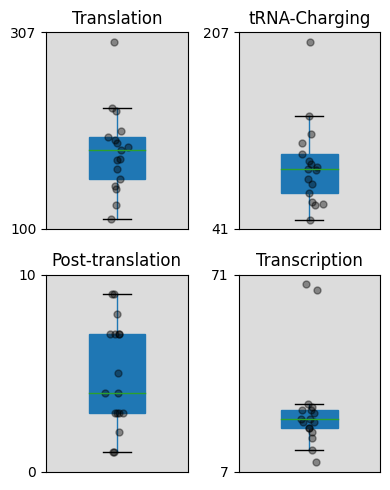

In [35]:
fig,ax = plt.subplots(2,2,figsize=(4,5))
ax=ax.flatten()
for idx,c in enumerate(df1.columns[:-2]):
    bp = df1[[c]].boxplot(vert=True,ax=ax[idx],grid=False,widths = [0.4],showfliers=False,
                          patch_artist = True, return_type='both')
    Y = np.random.normal(1., 0.04,size = df1[[c]].shape[0])
    for i,y in zip(df1[[c]].values,Y):
        ax[idx].plot(y,i,'o',color='k',alpha=0.4,markersize=5)
    
#     for row_key, (ax,row) in bp_dict.iteritems():
#         for i,box in enumerate(row['boxes']):
#             box.set_facecolor('white')
    ax[idx].set_facecolor("gainsboro")
    
    
    start, end = [int(i) for i in ax[idx].get_ylim()]
    ax[idx].set_ylim([max(0,start),end])
    ax[idx].set_title(c)
    ax[idx].yaxis.set_ticks([max(0,start),end+1])
    ax[idx].xaxis.set_ticks([])
plt.tight_layout()
plt.savefig('./figures/Fig2g.svg',format='SVG')

Average mapped gene functions in dME-models

In [36]:
df1.mean()

Translation         181.588235
tRNA-Charging        94.882353
Post-translation      4.882353
Transcription        27.588235
none                  6.705882
Mapped              308.941176
dtype: float64

Mapped gene functions in the dME-models of published ME-models

In [37]:
df2

,Translation,tRNA-Charging,Post-translation,Transcription,none
C. ljungdahlii,195.0,95.0,3.0,20.0,1.0
B. subtilis,157.0,107.0,2.0,23.0,1.0
T. maritima,138.0,67.0,3.0,15.0,1.0
E. coli,211.0,90.0,24.0,29.0,3.0


Final mapped gene functions in uME-models

In [38]:
df3 = pandas.DataFrame.from_dict(fct2).T.fillna(0)[functions]
df3 = df3.rename({k:k + '_curated' for k in df3.index})
df3

,Translation,tRNA-Charging,Post-translation,Transcription
T. maritima_curated,141.0,90.0,3.0,13.0
E. coli_curated,223.0,154.0,29.0,37.0
C. ljungdahlii_curated,212.0,129.0,10.0,21.0
B. subtilis_curated,210.0,136.0,13.0,38.0


Merge the gene functions of dME-models and published ME-models

In [39]:
order3 = [order2[i//2] for i in range(0,len(order2)*2)]
order3 = [i if not idx%2 else i + '_curated' for idx,i in enumerate(order3)]
df4 = pandas.concat([df2,df3]).fillna(0.).loc[order3]
df4.sum(axis=1)

C. ljungdahlii            314.0
C. ljungdahlii_curated    372.0
B. subtilis               290.0
B. subtilis_curated       397.0
T. maritima               224.0
T. maritima_curated       247.0
E. coli                   357.0
E. coli_curated           443.0
dtype: float64

Fraction of gene functions already mapped in the dME-models (compared to final uME-models)

In [40]:
gfp1 = df4[df4.index.str.contains("curated")].drop("none",axis=1).sum(axis=1)
gfp2 = df4[~df4.index.str.contains("curated")].drop("none",axis=1).sum(axis=1)
pandas.DataFrame(gfp2.values/gfp1.values,index=gfp2.index,columns=["fraction"]).sort_values("fraction")

,fraction
B. subtilis,0.727960
E. coli,0.799097
C. ljungdahlii,0.841398
T. maritima,0.902834


Heatmap of mapped gene functions in the dME-models by category

/tmp/ipykernel_146904/3378120587.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlGnBu').copy()


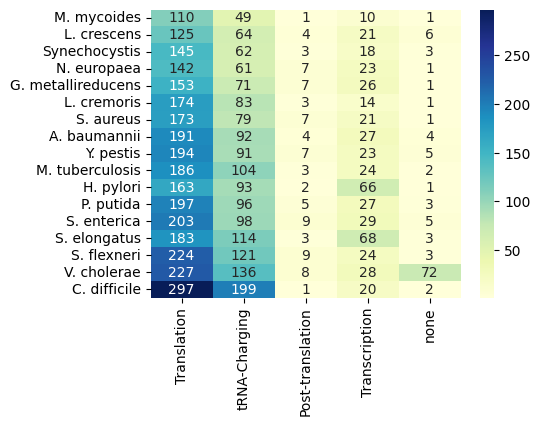

In [41]:
cmap = plt.cm.get_cmap('YlGnBu').copy()
# cmap.set_bad('midnightblue') # color of mask on heatmap
cmap.set_under('white')

tmp = df1[functions + ["none"]]
fig,ax = plt.subplots(figsize = (1.0 * tmp.shape[1], 0.22 * tmp.shape[0]))
hm = sns.heatmap(tmp,vmin=tmp.min().min(),vmax=tmp.max().max(), annot=True,fmt="g",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2e.svg',format='SVG')

Heatmap of total mapped gene functions in the dME-models

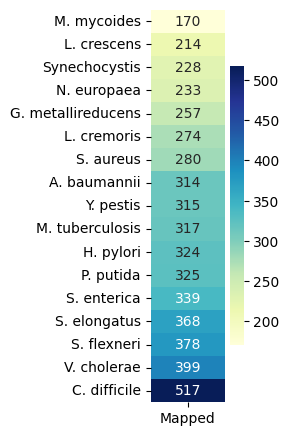

In [42]:
tmp = df1[["Mapped"]]
fig,ax = plt.subplots(figsize = (1.2, 0.3 * tmp.shape[0]))
hm = sns.heatmap(tmp, annot=True,fmt="g",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2e2.svg',format='SVG')

Heatmap comparing mapped gene functions in the dME-models and uME-models

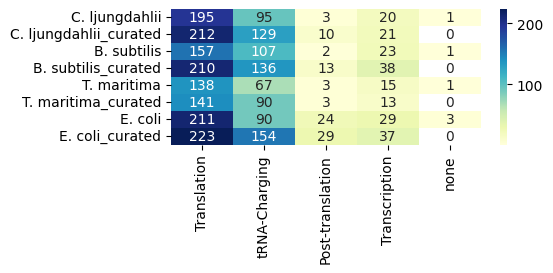

In [43]:
fig,ax = plt.subplots(figsize = (1.0 * df4.shape[1], 0.22 * df4.shape[0]))
hm = sns.heatmap(df4, annot=True,fmt="g",cmap=cmap,vmin=1,vmax=df4.max().max(),ax=ax)
plt.savefig('./figures/Fig2f.svg',format='SVG')

## Computation times

In [44]:
from datetime import datetime
import re

Function to calculate times from log files in each organism's directory.

Run <code> bash get_times.sh </code> in clean/ to get the files necessary for this part.


In [45]:
def get_times(filename):
    times = {}
    for l in open(filename,"r").readlines():
        if l == '\n':continue
        org = re.findall("(?<=\=\=\> \./)[a-z]*",l)
        if org:
            current_org = org[0]
            continue
        tstring = l.split(",")[0]
        dt = datetime.strptime(tstring,"%Y-%m-%d %H:%M:%S")
        times[current_org] = dt
    return times

Get computation times

In [46]:
b1 = get_times("./clean/builder_time1.txt")
b2 = get_times("./clean/builder_time2.txt")
r1 = get_times("./clean/recon_time1.txt")
r2 = get_times("./clean/recon_time2.txt")
t1 = get_times("./clean/ts_time1.txt")
t2 = get_times("./clean/ts_time2.txt")

Get computation times

In [47]:
times = {}
for org in b1.keys():
    # if org in exclude: continue
    times[org] = {
        "sync" : (b2[org] - b1[org]).total_seconds()/60.0,
        "recon" : (r2[org] - r1[org]).total_seconds()/60.0,
        "troub" : (t2[org] - t1[org]).total_seconds()/60.0
    }
df = pandas.DataFrame.from_dict(times).T.rename(names)

Computation times for dME-model reconstruction

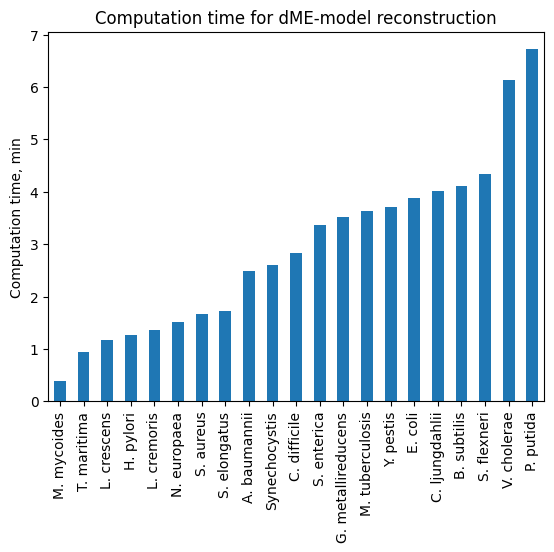

In [48]:
df[['sync','recon']].T.sum().sort_values().plot.bar()
plt.title("Computation time for dME-model reconstruction")
plt.ylabel("Computation time, min")
plt.savefig("./figures/build_timespans.svg",format="SVG")

Average time for dME-model reconstruction in minutes

In [49]:
df[['sync','recon']].sum(1).mean()

2.922222222222222

Computation times for dME-model troubleshooting

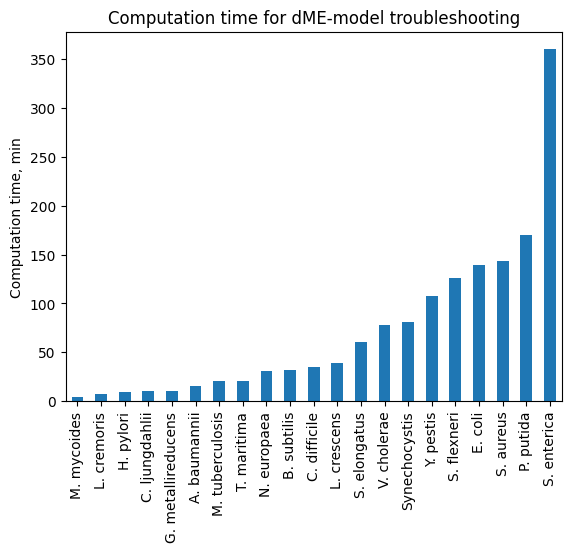

In [50]:
(df[["troub"]].T.sum()).sort_values().plot.bar()
plt.title("Computation time for dME-model troubleshooting")
plt.ylabel("Computation time, min")
plt.savefig("./figures/troubleshoot_timespans.svg",format="SVG")

Average time for dME-model troubleshooting in minutes

In [51]:
df[['troub']].sum(1).mean()

71.65952380952383

## Notes

#### Clostridium had a lot of manual curation on M-reactions

In [52]:
df2=specs_df[specs_df['published']>0]
(df2['published'] - df2['coralme']).div(df2['published'] - df2['mmodel'])

T. maritima       0.147929
C. ljungdahlii    0.320122
B. subtilis       0.160338
E. coli           0.215434
dtype: float64

In [53]:
df2=specs_df[specs_df['published']>0]
1 - (df2['published'] - df2['coralme']).div(df2['published'] - df2['mmodel'])

T. maritima       0.852071
C. ljungdahlii    0.679878
B. subtilis       0.839662
E. coli           0.784566
dtype: float64

In [54]:
me1 = models['curated']['cljungdahlii']

In [55]:
me2 = models['clean']['cljungdahlii']

In [56]:
len(me1.all_genes)

972

In [57]:
len(me2.all_genes)

860

In [58]:
len(me1.gem.genes)

638

In [59]:
from collections import defaultdict
d = defaultdict(int)
for i in set(i.id for i in me1.all_genes) - set(i.id for i in me2.all_genes):
    g = me1.get(i)
#     print(g.id,g.functions)    
    if any('Metabolic' in j for j in g.functions):
        d['Metabolic'] += 1
    else:
        d['E'] += 1
d

defaultdict(int, {'Metabolic': 66, 'E': 56})